# Joining and Visualizing Weather Data

We'll begin by preparing, loading, and joining the data. Then we'll proceed to show five visualizations:

1. Scatter Plot of Windspeed and Average Temperature
2. Line Graph of Max Temp, by Latitude, for June and December
3. Line Graph of Temperatures Over Time
4. Distributions of Maximum Temperature, 11/6/2016 vs 11/3/2024
5. Bar Graph of Windspeed in Fort Lauderdale, FL, Before and During 2016 Storms

We'll conclude with a summary of lessons learned an analysis of ethical considerations.

## Data Preparation
First we will set up the database, and then we will load the three datasets:
* "Weather" data from Milestone 2, which is all of the 2016 weather, by week across 316 locations.
* "Storms" data from Milestone 3, which is the 2016 storms.
* "Recent" data from Milestone 4, which is recent data across the 316 locations from the "Weather" dataset.

In [180]:
# Import necessary packages
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import math
import datetime

# Set up the database.
con = sqlite3.connect("milestone5.sqlite")
def query(sql):
    return pd.read_sql_query(sql, con)

In [181]:
# Load the "Weather" data from Milestone 2 into the database.
weather = pd.read_csv("JacobsonDSC540Milestone2_weather.csv")
weather.to_sql('WEATHER', con, if_exists='replace', index=False)
query("select * from WEATHER limit 1")

,Unnamed: 0,precipitation,date,month,day,year,long_city,code,location,long_state,avg_temp,max_temp,min_temp,wind_direction,wind_speed,epoch,city,state,latitude,longitude
0,0,0.0,2016-01-03,1,3,2016,Birmingham,BHM,"Birmingham, AL",Alabama,39,46,32,33,4.33,1451779200,Birmingham,AL,33.520682,-86.802433


In [182]:
# Load the "Storms" data from Milestone 3 into the database.
storms = pd.read_csv("JacobsonDSC540Milestone3_storms.csv")
storms.to_sql('STORMS', con, if_exists='replace', index=False)
query("select * from STORMS limit 1")

,Stormname,Dates active,Stormcategoryat peak intensity,Max 1-minwindmph (km/h),Min.press.(mbar),Areas affected,Damage(USD),Deaths,Ref(s),start,end,start_epoch,end_epoch
0,Alex,January 12-15,Category 1 hurricane,85 (140),981,"The Bahamas,Bermuda,Azores,Southern Greenland",Minimal,(1),[39],"January 12, 2016","January 15, 2016",1452574800,1452834000


In [183]:
# Load the "Recent" data from Milestone 4 into the database.
recent = pd.read_csv("JacobsonDSC540Milestone4_today.csv")
recent.to_sql('RECENT', con, if_exists='replace', index=False)
query("select * from RECENT limit 1")

,input_latitude,input_longitude,latitude,longitude,max_temp,min_temp,wind_direction,wind_speed,epoch,name
0,33.520682,-86.802433,33.5207,-86.8024,71,69,220,0.89,1730683592,Birmingham


Now we will join the data together. These are the joins:
* From "Weather" to "Storms" we will join based on epoch. We'll join when the weather observation epoch is within the start and end epoch of the storm.
* From "Weather" to "Recent" we will join based on latitude and longitude. We'll join when the location data matches.

In [184]:
# Join the three datasets and measure the shape of the results.
joined = query("""
select * 
from weather a
join storms b on a.epoch between b.start_epoch and b.end_epoch
join recent c on a.latitude=c.input_latitude and a.longitude=c.input_longitude
"""
     )
print("The joined dataset has "+str(joined.shape[0])+" rows and "+str(joined.shape[1])+" columns.")

The joined dataset has 3483 rows and 43 columns.


## Scatter Plot of Windspeed and Average Temperature
We'll show the relationship of windpeed and temperature by using a scatter plot. We'll only need the "Weather" dataset for this, but we'll use all 2016 data and locations. To focus in on the most common comparisons, we'll remove outliers with windspeed greater than 20.

In [185]:
scatter = query("select wind_speed,avg_temp from weather")
scatter.head()

,wind_speed,avg_temp
0,4.33,39
1,3.86,39
2,9.73,46
3,6.86,45
4,7.80,34


Removing outliers with wind_speed > 20 reducted row count by 59


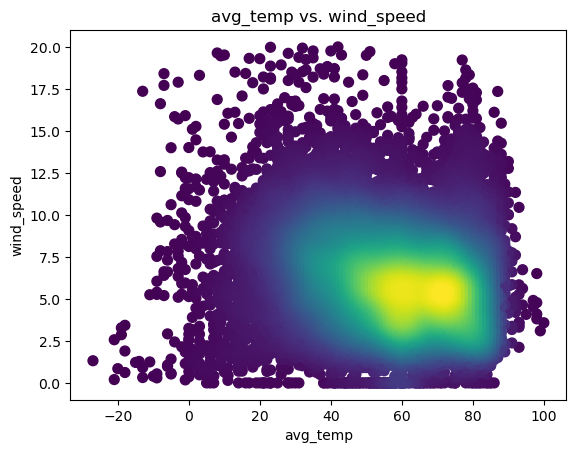

In [186]:
before  = scatter.shape[0]
scatter = scatter.drop(scatter[scatter.wind_speed >20].index)
after   = scatter.shape[0]
print("Removing outliers with wind_speed > 20 reducted row count by "+str(before-after))

# Here is a function to plot a scatter plot with density,
# adapted from https://stackoverflow.com/a/20107592.
def density_scatter(df,x_name,y_name):
    x,y = df[x_name].to_numpy(),df[y_name].to_numpy()
    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    fig, ax = plt.subplots()
    cax = ax.scatter(x, y, c=z, s=50, edgecolor=None)
    plt.title(x_name +" vs. "+y_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()
    
density_scatter(scatter,'avg_temp','wind_speed')

## Line Graph of Max Temp, by Latitude, for June and December
We'll show the maximum temperature by latitude for Summer (June) and Winter (December). Again, we'll only need the weather dataset for this.

Max latitude: 72 Min latitude: 18 Bin size: 1


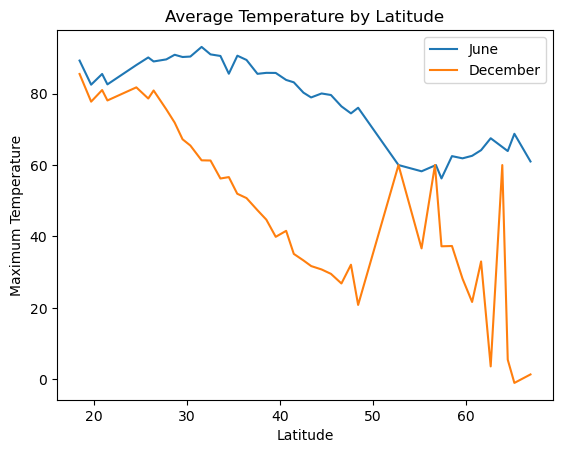

In [187]:
latitude_temp = query("select latitude,max_temp,month from weather")

# Figure out bins for our grouping.
max_lat = math.ceil(latitude_temp.latitude.max())
min_lat = math.floor(latitude_temp.latitude.min())
bin_size = int((max_lat-min_lat)/50)
print("Max latitude: "+str(max_lat)+" Min latitude: "+
      str(min_lat) + " Bin size: "+str(bin_size))
latitude_temp['lat_group'] = pd.cut(latitude_temp.latitude, bins=range(min_lat, max_lat, bin_size), right=False)

def get_season(df,month):
    season = df[df.month == month]
    return season.groupby('lat_group',observed=True).mean()
    
summer = get_season(latitude_temp,6)
winter = get_season(latitude_temp,12)

plt.plot(summer.latitude,summer.max_temp,label="June")  # Plot the chart
plt.plot(winter.latitude,winter.max_temp,label="December")  # Plot the chart
plt.title("Average Temperature by Latitude")
plt.xlabel("Latitude")
plt.ylabel("Maximum Temperature")
plt.legend()
plt.show()  # display



## Line Graph of Temperatures Over Time
We'll next show temperatures (min,max,avg) of all locations over time. We'll need just the weather dataset for this.

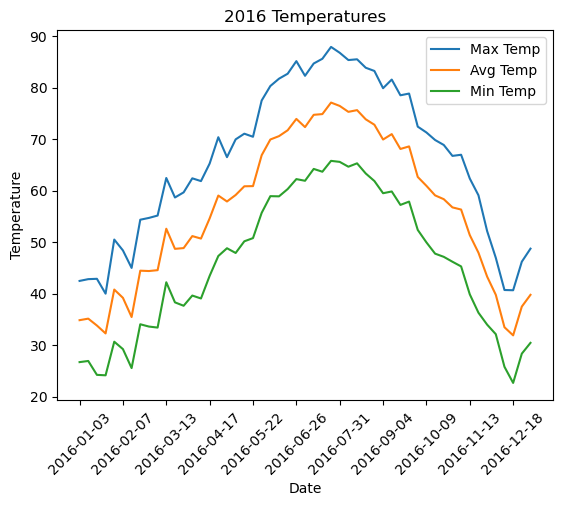

In [188]:
temps = query("select date,min_temp,avg_temp,max_temp,month from weather")
temps = temps.groupby("date").mean().reset_index()
xticks = temps.date[0::5]
plt.plot(temps['date'],temps.max_temp,label="Max Temp")
plt.plot(temps.date,temps.avg_temp,label="Avg Temp")
plt.plot(temps.date,temps.min_temp,label="Min Temp")
plt.title("2016 Temperatures")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.xticks(xticks,rotation=45)
plt.legend()
plt.show()  # display

## Distributions of Maximum Temperature, 11/6/2016 vs 11/3/2024
For this we will need both the "Weather" and the "Recent" datasets.

In [189]:
# Using the epoch of the recent dataset, find the month and day
recent_one = query("select max(epoch) as epoch from recent")
recent_epoch = recent_one.iloc[0].epoch
datetime_object = datetime.datetime.fromtimestamp(recent_epoch)
month = datetime_object.month
day = datetime_object.day

# Get the day in the weather data that follows our recent day
close = query("select max(day) as day from weather where month="+str(month)+" and day>"+str(day))
close_day = close.iloc[0].day

# Obtain the 2016 and recent temps by location for that day.
full = query("""
select 
    a.latitude,
    a.longitude,
    a.max_temp as past_temp,
    b.max_temp as recent_temp 
from weather a 
join recent b on 
    a.latitude=b.input_latitude 
    and a.longitude=b.input_longitude
where month={month} and day={day}
""".format(month=month,day=close_day)
            )
full.head()

,latitude,longitude,past_temp,recent_temp
0,33.520682,-86.802433,65,71
1,34.729847,-86.585901,64,67
2,30.686734,-88.084893,73,75
3,32.366966,-86.300648,73,71
4,61.216313,-149.894852,24,34


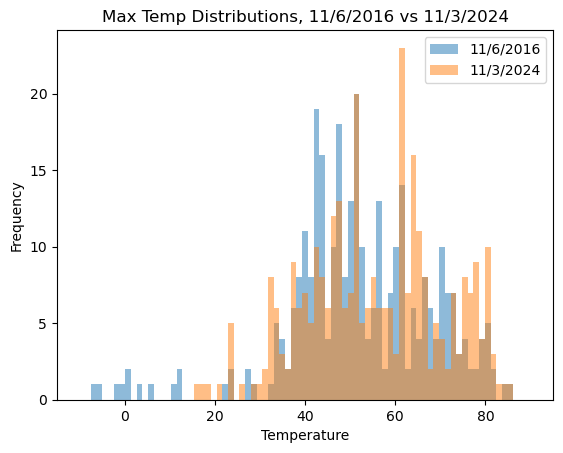

In [190]:
# Plot the distributions, using a method adapted
# from https://stackoverflow.com/a/6873956
x = full.past_temp.to_numpy()
y = full.recent_temp.to_numpy()

bins = np.linspace(-10, 90, 80)

plt.hist(x, bins, alpha=0.5, label='11/6/2016')
plt.hist(y, bins, alpha=0.5, label='11/3/2024')

plt.legend(loc='upper right')
plt.title("Max Temp Distributions, 11/6/2016 vs 11/3/2024")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## Bar Graph of Windspeed in Fort Lauderdale, FL, Before and During 2016 Storms

For this we will need both the "Weather" and the "Storms" datasets.

In [191]:
# Find Relevant Storms and Wind data
southeast = query("select \"Dates active\",Stormname,start_epoch,end_epoch from storms where lower(\"Areas affected\") like '%southeast%'")
southeast

,Dates active,Stormname,start_epoch,end_epoch
0,May 27 - June 4,Bonnie,1464321600,1465012800
1,September 13-18,Julia,1473739200,1474171200
2,September 28 - October 9,Matthew,1475035200,1475985600


In [196]:
# For each row, we'll want to grab the weather data before and 
# during that storm
def before_and_after(row):
    epoch = row.start_epoch
    base_query = """
select date,wind_speed 
from weather 
where location='Fort Lauderdale, FL'
and epoch
"""
    before = query("""
{base_query} < {epoch} order by epoch DESC limit 1
""".format(base_query=base_query,epoch=epoch)
              )
    after = query("""
{base_query} > {epoch} order by epoch ASC limit 5
""".format(base_query=base_query,epoch=epoch)
             )
    before = before.iloc[0].wind_speed,
    after = after.iloc[0].wind_speed,
    return before[0],after[0]
    
labels_list = []
before_list = []
after_list  = []
for index, row in southeast.iterrows():
    labels_list.append(row["Stormname"]+", "+row["Dates active"])
    before,after = before_and_after(row)
    before_list.append(before)
    after_list.append(after)
ready = pd.DataFrame.from_dict({
    "Storm":labels_list,
    "Before":before_list,
    "During":after_list
})

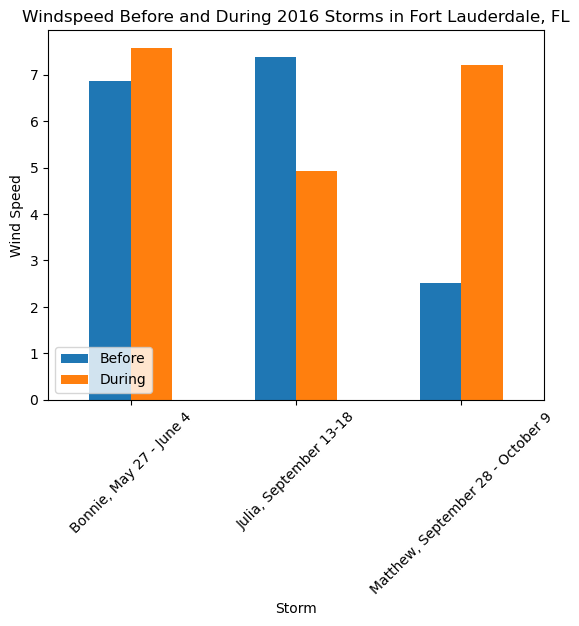

In [194]:
ready.plot.bar(x='Storm', y=['Before', 'During'])
plt.legend(loc='lower left')
plt.title("Windspeed Before and During 2016 Storms in Fort Lauderdale, FL")
plt.xlabel("Storm")
plt.ylabel("Wind Speed")
plt.xticks(rotation=45)
plt.show()

## Summary and Ethical Analysis

In addition to the technical skills of working with the data wrangling and visualization software, I realized that it is tricky to figure out which visualizations to do. Obviously many more could be done, but it took significant work to get to the point where you could even test the quality of the visualization. At that point, the visualization might not be that interesting but you have already put significant time into developing it. For example, the first visualization shows little correlation between the two variables, but it does show the average windspeed and temperature very clearly. In this way, the visualization adds little insight over a simple mean calculation. Similarly, the last visualization does not show as dramatic a change in windspeed as I'd expect for a city in the path of these storms. Both of these visualizations took significant work to produce, but were not as insightful as I hoped they would be. I think there is a principle here that demonstrates the value of an experienced data scientist in intuiting what visualizations are worth investing time into making. In contrast, the temperatures over time graph nicely confirms the understanding of warmer summers and cooler winters, and the latitude graph shows that this is not as consistent in the norther latitudes. It could be that these were just some heat waves, but it is clear that the temperature deltas cause by latitude is much greater during the winter.

Regarding ethical considerations of this data, there is not much concern with weather data as it was published for precisely this purpose. However, it is worth mentioning that these storms were quite damaging, especially Hurricane Matthew. They resulted in property damage and, tragically, many deaths. When working in data and programming it is easy to get lost in the mechanics of working through the data, but it is important to remain in touch with the real-life implications of the data that you are handling and take time out of your work to make sure you are remaining sensitive to thi.
